# 2. Models
This script includes the LSTM models for the three different sets. The LSTM is backed by CuDNN (CuDNNLSTM). The script can only run on GPU, with the TensorFlow backend. In Google Colab, you can switch to GPU via: Runtime > Change runtime type > Hardware accelerator > GPU.

## 2.1. Preliminary

Import modules.

In [0]:
from google.colab import drive
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, CuDNNLSTM
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from numpy import argmax
from sklearn.utils.multiclass import unique_labels

Mount drive and change current working directory.

In [0]:
drive.mount('/content/drive', force_remount = True)
os.chdir("/content/drive/My Drive/thesis/")

Set seed to prevent randomness on multiple executions of the code.

In [0]:
np.random.seed(1)

Create function for confusion matrix (source: [scikit-learn developers](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)).


In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.gist_yarg):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right", rotation_mode="anchor")
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.autoscale()

##2.2. Data

### 2.2.1. Import

The data is available in the 'input' folder. Import the NumPy array objects.

In [0]:
x_HAART  = np.load('input/x_HAART.npy')
y_HAART  = np.load('input/y_HAART.npy')
x_COST  = np.load('input/x_COST.npy', allow_pickle = True)
y_COST  = np.load('input/y_COST.npy')
x_COSTHAART  = np.load('input/x_COSTHAART.npy', allow_pickle = True)
y_COSTHAART  = np.load('input/y_COSTHAART.npy')

### 2.2.2. Dataset splitting

Create a function what can be used for a 60/20/20 split. First the input wil be splitted by the train_frac (which will be 

In [0]:
def data_split(predictor_variables, target_variables, train_frac, random_state = None):
    "Create a Train/Test/Val set given a ratio of the train set to the whole dataset."
    from sklearn.model_selection import train_test_split #Split arrays or matrices into random train and test subsets.
    x_train, x_tmp, y_train, y_tmp = train_test_split(predictor_variables, target_variables, train_size = train_frac, random_state = random_state)
    x_val, x_test, y_val, y_test = train_test_split(x_tmp, y_tmp, train_size = 0.5, random_state = random_state)
    return x_train, x_val, x_test, y_train, y_val, y_test

Create the split for both the COST set, HAART set, and combined set.

In [0]:
x_trn_H, x_val_H, x_tst_H, y_trn_H, y_val_H, y_tst_H  = data_split(x_HAART, y_HAART, 0.6, random_state = 1)
x_trn_C, x_val_C, x_tst_C, y_trn_C, y_val_C, y_tst_C  = data_split(x_COST, y_COST, 0.6, random_state = 1)
x_trn_HC, x_val_HC, x_tst_HC, y_trn_HC, y_val_HC, y_tst_HC = data_split(x_COSTHAART, y_COSTHAART, 0.6, random_state = 1)

##2.3. Model 1: HAART

This model obtained classification results of 49.3% on the training set and 47.2% on the validation set.

In [0]:
model = Sequential() #Create model layer-by-layer.

model.add(CuDNNLSTM(54, kernel_regularizer = l2(l = 0.001), input_shape =(x_trn_H.shape[1:]), return_sequences = True))
          
model.add(CuDNNLSTM(27, kernel_regularizer = l2(l = 0.001)))
          
model.add(Dense(6, activation = "softmax")) #Use softmax for multi-class classification.

opt = tf.keras.optimizers.Adam(lr=0.001)

es = EarlyStopping(monitor = 'val_acc', 
                   mode = 'max', 
                   patience = 4,
                   restore_best_weights = True)

model.compile(loss = "categorical_crossentropy",
              optimizer = opt,
              metrics = ["accuracy"])

history_H = model.fit(x_trn_H, 
                      y_trn_H,
                      batch_size = 5,
                      epochs = 100,
                      callbacks = [es], 
                      validation_data = (x_val_H, y_val_H))

Train on 426 samples, validate on 142 samples
Epoch 1/100
426/426 [==============================] - 7s 16ms/sample - loss: 1.9060 - acc: 0.2277 - val_loss: 1.7986 - val_acc: 0.3028
Epoch 2/100
426/426 [==============================] - 2s 4ms/sample - loss: 1.7403 - acc: 0.3498 - val_loss: 1.7507 - val_acc: 0.2887
Epoch 3/100
426/426 [==============================] - 2s 4ms/sample - loss: 1.6405 - acc: 0.4155 - val_loss: 1.5382 - val_acc: 0.4225
Epoch 4/100
426/426 [==============================] - 2s 4ms/sample - loss: 1.5311 - acc: 0.4108 - val_loss: 1.6114 - val_acc: 0.3873
Epoch 5/100
426/426 [==============================] - 2s 4ms/sample - loss: 1.4954 - acc: 0.4531 - val_loss: 1.5834 - val_acc: 0.4225
Epoch 6/100
426/426 [==============================] - 2s 4ms/sample - loss: 1.4065 - acc: 0.5141 - val_loss: 1.5225 - val_acc: 0.4507
Epoch 7/100
426/426 [==============================] - 2s 4ms/sample - loss: 1.4640 - acc: 0.4624 - val_loss: 1.6440 - val_acc: 0.3310
Epoch 8/

Calculate the test accuracy.

In [0]:
score, acc = model.evaluate(x_tst_H, y_tst_H)

print('Loss function:', score)
print('Test accuracy:', acc)

142/142 [==============================] - 0s 1ms/sample - loss: 1.4651 - acc: 0.4789
Loss function: 1.4650948517759081
Test accuracy: 0.47887325



Generate extra visual information for the report.

In [0]:
model.summary()

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_120 (CuDNNLSTM)   (None, 432, 54)           25920     
_________________________________________________________________
cu_dnnlstm_121 (CuDNNLSTM)   (None, 27)                8964      
_________________________________________________________________
dense_60 (Dense)             (None, 6)                 168       
Total params: 35,052
Trainable params: 35,052
Non-trainable params: 0
_________________________________________________________________


In [0]:
#Add an value at the beginning of the lists to get values on right axes.
history_H.history['acc'].insert(0,0.0)
history_H.history['val_acc'].insert(0,0.0)
history_H.history['loss'].insert(0,0.0)
history_H.history['val_loss'].insert(0,0.0)

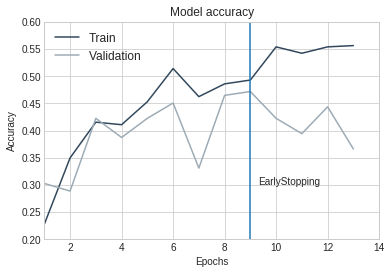

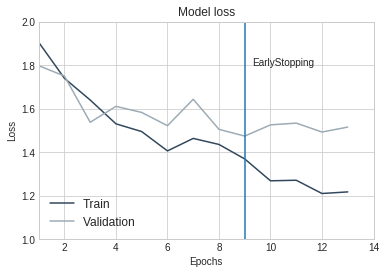

In [0]:
#Plot train and validation accuracy
acc = plt.style.use('seaborn-whitegrid')
acc = plt.plot(history_H.history['acc'], color = "#31475C")
acc = plt.plot(history_H.history['val_acc'], color = "#9DABB5")
acc = plt.title('Model accuracy')
acc = plt.ylabel('Accuracy')
acc = plt.xlabel('Epochs')
acc = plt.legend(['Train', 'Validation'], loc='upper left', fontsize = 12)
acc = plt.axvline(x=9)
acc = plt.xlim((1,14))
acc = plt.ylim((0.2,0.6))
acc = plt.text(9.3,0.3,'EarlyStopping')
acc = plt.savefig('figures/HAART_acc.png')
acc = plt.show()

#Plot train and validation loss
loss = plt.style.use('seaborn-whitegrid')
loss = plt.plot(history_H.history['loss'], color = "#31475C")
loss = plt.plot(history_H.history['val_loss'], color = "#9DABB5")
loss = plt.title('Model loss')
loss = plt.ylabel('Loss')
loss = plt.xlabel('Epochs')
loss = plt.legend(['Train', 'Validation'], loc='lower left', fontsize = 12)
loss = plt.axvline(x=9)
loss = plt.xlim((1,14))
loss = plt.ylim((1,2))
loss = plt.text(9.3,1.8,'EarlyStopping')
loss = plt.savefig('figures/HAART_loss.png')
loss = plt.show()

Create confusion matrix.

In [0]:
y_pred_H = model.predict_classes(x_tst_H)

counter = 0
y_tst_cat_H = []
for value in y_tst_H:
  y_tst_cat_H.append(str(argmax(y_tst_H[counter])))
  counter += 1

y_tst_H = np.array(y_tst_cat_H)
y_tst_H = y_tst_H.astype(int)

In [0]:
cnf_matrix = confusion_matrix(y_tst_H, y_pred_H, labels=[0,1,2,3,4,5])

HAART_cm = plot_confusion_matrix(cnf_matrix, classes=["pat","constant","rub","scratch","stroke","tickle"])

HAART_cm = plt.savefig('figures/HAART_cm.png')

##2.4. Model 2: CoST

This model obtained classification results of 64.9% on the training set and 61.4% on the validation set.

In [0]:
model = Sequential() #Create model layer-by-layer.

model.add(CuDNNLSTM(54, kernel_regularizer = l2(l = 0.001), input_shape =(x_trn_C.shape[1:]), return_sequences = True))

model.add(CuDNNLSTM(27, kernel_regularizer = l2(l = 0.001)))
          
model.add(Dense(6, activation = "softmax")) #Use softmax for multi-class classification.
          
opt = tf.keras.optimizers.Adam(lr=0.001)

es = EarlyStopping(monitor = 'val_loss', 
                   mode = 'min', 
                   patience = 35)
cp = ModelCheckpoint(monitor = 'val_acc',
                     mode = 'max',
                     filepath='/tmp/best_COST_score.hdf5', 
                     save_best_only = True)

model.compile(loss = "categorical_crossentropy",
              optimizer = opt,
              metrics = ["accuracy"])

history_C = model.fit(x_trn_C, 
                      y_trn_C,
                      batch_size = 15,
                      epochs = 500,
                      callbacks = [es, cp], 
                      validation_data = (x_val_C, y_val_C))  

Train on 2005 samples, validate on 668 samples
Epoch 1/500
2005/2005 [==============================] - 23s 12ms/sample - loss: 1.8457 - acc: 0.2195 - val_loss: 1.8076 - val_acc: 0.2365
Epoch 2/500
2005/2005 [==============================] - 7s 3ms/sample - loss: 1.7750 - acc: 0.2204 - val_loss: 1.7783 - val_acc: 0.2350
Epoch 3/500
2005/2005 [==============================] - 7s 3ms/sample - loss: 1.7922 - acc: 0.1955 - val_loss: 1.7860 - val_acc: 0.2246
Epoch 4/500
2005/2005 [==============================] - 7s 3ms/sample - loss: 1.7562 - acc: 0.2180 - val_loss: 1.7686 - val_acc: 0.2305
Epoch 5/500
2005/2005 [==============================] - 7s 3ms/sample - loss: 1.7664 - acc: 0.2254 - val_loss: 1.7867 - val_acc: 0.2036
Epoch 6/500
2005/2005 [==============================] - 7s 3ms/sample - loss: 1.7664 - acc: 0.2160 - val_loss: 1.7774 - val_acc: 0.1901
Epoch 7/500
2005/2005 [==============================] - 7s 3ms/sample - loss: 1.7202 - acc: 0.2509 - val_loss: 1.6759 - val_acc:

Calculate the test accuracy. Before calculating, first load the best model checkpoint based on the highest validation accuracy.

In [0]:
model.load_weights("/tmp/best_COST_score.hdf5")

In [0]:
score, acc = model.evaluate(x_tst_C, y_tst_C)

print('Loss function:', score)
print('Test accuracy:', acc)

669/669 [==============================] - 1s 2ms/sample - loss: 1.1222 - acc: 0.5725
Loss function: 1.122156651387122
Test accuracy: 0.57249624


Generate extra visual information for the report.

In [0]:
model.summary()

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_130 (CuDNNLSTM)   (None, 432, 54)           25920     
_________________________________________________________________
cu_dnnlstm_131 (CuDNNLSTM)   (None, 27)                8964      
_________________________________________________________________
dense_65 (Dense)             (None, 6)                 168       
Total params: 35,052
Trainable params: 35,052
Non-trainable params: 0
_________________________________________________________________


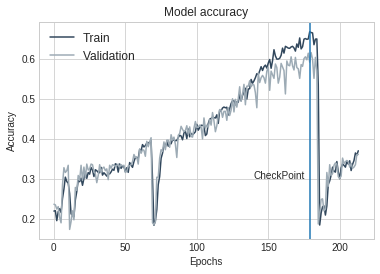

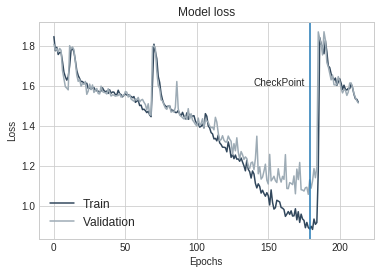

In [0]:
#Plot train and validation accuracy
acc = plt.style.use('seaborn-whitegrid')
acc = plt.plot(history_C.history['acc'], color = "#31475C")
acc = plt.plot(history_C.history['val_acc'], color = "#9DABB5")
acc = plt.title('Model accuracy')
acc = plt.ylabel('Accuracy')
acc = plt.xlabel('Epochs')
acc = plt.legend(['Train', 'Validation'], loc = 'upper left', fontsize = 12)
acc = plt.axvline(x = 179)
acc = plt.text(140, 0.3, 'CheckPoint')
acc = plt.savefig('figures/COST_acc.png')
acc = plt.show()

#Plot train and validation loss
loss = plt.style.use('seaborn-whitegrid')
loss = plt.plot(history_C.history['loss'], color = "#31475C")
loss = plt.plot(history_C.history['val_loss'], color = "#9DABB5")
loss = plt.title('Model loss')
loss = plt.ylabel('Loss')
loss = plt.xlabel('Epochs')
loss = plt.legend(['Train', 'Validation'], loc = 'lower left', fontsize = 12)
loss = plt.axvline(x = 179)
loss = plt.text(140, 1.6, 'CheckPoint')
loss = plt.savefig('figures/COST_loss.png')
loss = plt.show()

Create confusion matrix.

In [0]:
y_pred_C = model.predict_classes(x_tst_C)

counter = 0
y_tst_cat_C = []
for value in y_tst_C:
  y_tst_cat_C.append(str(argmax(y_tst_C[counter])))
  counter += 1

y_tst_C = np.array(y_tst_cat_C)
y_tst_C = y_tst_C.astype(int)

In [0]:
cnf_matrix = confusion_matrix(y_tst_C, y_pred_C, labels=[0,1,2,3,4,5])

COST_cm = plot_confusion_matrix(cnf_matrix, classes=["pat","constant","rub","scratch","stroke","tickle"])

COST_cm = plt.savefig('figures/COST_cm.png')

##2.5. Model 3: CoST-HAART

This model obtained classification results of 49.2% on the training set and 46.9% on the validation set.

In [0]:
model = Sequential()

model.add(CuDNNLSTM(54, kernel_regularizer = l2(l = 0.001), input_shape =(x_trn_HC.shape[1:]), return_sequences = True))

model.add(CuDNNLSTM(27, kernel_regularizer = l2(l = 0.001)))
          
model.add(Dense(6, activation = "softmax"))
          
opt = tf.keras.optimizers.Adam(lr=0.001)

es = EarlyStopping(monitor = 'val_loss', 
                   mode = 'min', 
                   patience = 10)
cp = ModelCheckpoint(monitor = 'val_acc',
                     mode = 'max',
                     filepath='/tmp/best_HC_score.hdf5', 
                     save_best_only = True)

model.compile(loss = "categorical_crossentropy",
              optimizer = opt,
              metrics = ["accuracy"])

history_HC = model.fit(x_trn_HC, 
                       y_trn_HC,
                       batch_size = 5,
                       epochs = 100,
                       callbacks = [es, cp], 
                       validation_data = (x_val_HC, y_val_HC))  

Train on 2431 samples, validate on 810 samples
Epoch 1/100
2431/2431 [==============================] - 17s 7ms/sample - loss: 1.8315 - acc: 0.2143 - val_loss: 1.8045 - val_acc: 0.2148
Epoch 2/100
2431/2431 [==============================] - 12s 5ms/sample - loss: 1.7590 - acc: 0.2411 - val_loss: 1.7657 - val_acc: 0.2407
Epoch 3/100
2431/2431 [==============================] - 13s 5ms/sample - loss: 1.7455 - acc: 0.2345 - val_loss: 1.7555 - val_acc: 0.2222
Epoch 4/100
2431/2431 [==============================] - 13s 5ms/sample - loss: 1.6954 - acc: 0.2830 - val_loss: 1.6972 - val_acc: 0.2778
Epoch 5/100
2431/2431 [==============================] - 13s 5ms/sample - loss: 1.6591 - acc: 0.2937 - val_loss: 1.6461 - val_acc: 0.3012
Epoch 6/100
2431/2431 [==============================] - 13s 5ms/sample - loss: 1.6334 - acc: 0.3200 - val_loss: 1.6675 - val_acc: 0.2914
Epoch 7/100
2431/2431 [==============================] - 13s 5ms/sample - loss: 1.6342 - acc: 0.3270 - val_loss: 1.6845 - val

Calculate the test accuracy. Before calculating, first load the best model checkpoint based on the highest validation accuracy.

In [0]:
model.load_weights("/tmp/best_HC_score.hdf5")

In [0]:
score, acc = model.evaluate(x_tst_HC, y_tst_HC)

print('Loss function:', score)
print('Test accuracy:', acc)

811/811 [==============================] - 1s 1ms/sample - loss: 1.2911 - acc: 0.4784
Loss function: 1.291060526773756
Test accuracy: 0.4784217


Generate extra visual information for the report.

In [0]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_12 (CuDNNLSTM)    (None, 432, 54)           25920     
_________________________________________________________________
cu_dnnlstm_13 (CuDNNLSTM)    (None, 27)                8964      
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 168       
Total params: 35,052
Trainable params: 35,052
Non-trainable params: 0
_________________________________________________________________


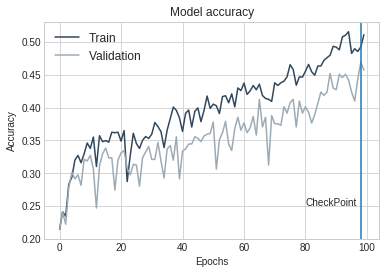

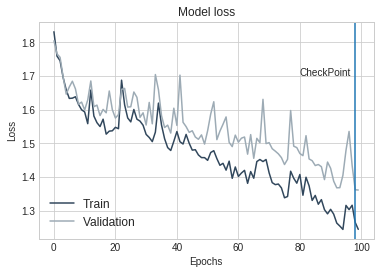

In [0]:
#Plot train and validation accuracy
acc = plt.style.use('seaborn-whitegrid')
acc = plt.plot(history_HC.history['acc'], color = "#31475C")
acc = plt.plot(history_HC.history['val_acc'], color = "#9DABB5")
acc = plt.title('Model accuracy')
acc = plt.ylabel('Accuracy')
acc = plt.xlabel('Epochs')
acc = plt.legend(['Train', 'Validation'], loc = 'upper left', fontsize = 12)
acc = plt.axvline(x = 98)
acc = plt.text(80, 0.25, 'CheckPoint')
acc = plt.savefig('figures/HAARTCOST_acc.png')
acc = plt.show()

#Plot train and validation loss
loss = plt.style.use('seaborn-whitegrid')
loss = plt.plot(history_HC.history['loss'], color = "#31475C")
loss = plt.plot(history_HC.history['val_loss'], color = "#9DABB5")
loss = plt.title('Model loss')
loss = plt.ylabel('Loss')
loss = plt.xlabel('Epochs')
loss = plt.legend(['Train', 'Validation'], loc = 'lower left', fontsize = 12)
loss = plt.axvline(x = 98)
loss = plt.text(80, 1.70, 'CheckPoint')
loss = plt.savefig('figures/HAARTCOST_loss.png')
loss = plt.show()

Create confusion matrix.

In [0]:
y_pred_HC = model.predict_classes(x_tst_HC)

counter = 0
y_tst_cat_HC = []
for value in y_tst_HC:
  y_tst_cat_HC.append(str(argmax(y_tst_HC[counter])))
  counter += 1

y_tst_HC = np.array(y_tst_cat_HC)
y_tst_HC = y_tst_HC.astype(int)

In [0]:
cnf_matrix = confusion_matrix(y_tst_HC, y_pred_HC, labels=[0,1,2,3,4,5])

COSTHAART_cm = plot_confusion_matrix(cnf_matrix, classes=["pat","constant","rub","scratch","stroke","tickle"])

COSTHAART_cm = plt.savefig('figures/COSTHAART_cm.png')